<a href="https://colab.research.google.com/github/shemaaali/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment/Predicting_Hotel_Booking_Status1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [619]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    url_train = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/train.csv'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap
    !pip install scikitplot

In [604]:
# Some imports setup for the environment for python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Some imports setup for the environment for machine learnig
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

In [605]:
# Loading the dataset file and read it
url_hotel = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/hotel_bookings.csv'

hotel_booked = pd.read_csv(url_hotel)

print(hotel_booked.shape)
hotel_booked.head()

(119390, 32)


hotel  is_canceled  ...  reservation_status  reservation_status_date
0  Resort Hotel            0  ...           Check-Out               2015-07-01
1  Resort Hotel            0  ...           Check-Out               2015-07-01
2  Resort Hotel            0  ...           Check-Out               2015-07-02
3  Resort Hotel            0  ...           Check-Out               2015-07-02
4  Resort Hotel            0  ...           Check-Out               2015-07-03

[5 rows x 32 columns]

### Choosing The Target That I am Going To Predict

### Which column in my tabular dataset will I predict?

In [606]:
# some description about reservation_status
hotel_booked['reservation_status'].describe()

count        119390
unique            3
top       Check-Out
freq          75166
Name: reservation_status, dtype: object

In [607]:
# Derive a binary classification target
# Drope all unuseful hotel booking
hotel_booked['reservation_status']
# replace N-Show status canceled status(added to Canceled)
hotel_booked['reservation_status'] = hotel_booked['reservation_status'].replace({'No-Show':'Canceled'})
hotel_booked = hotel_booked.dropna(subset=['reservation_status'])
hotel_booked['reservation_status'] = hotel_booked['reservation_status'].apply(lambda x: 0 if x =='Canceled' else 1)

### How is my target distributed?

In [608]:
# Define a status hotel booking as having reservation_status of  cheked out, canceled, or no show
hotel_booked['reservation_status'].describe()

count    119390.000000
mean          0.629584
std           0.482918
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: reservation_status, dtype: float64

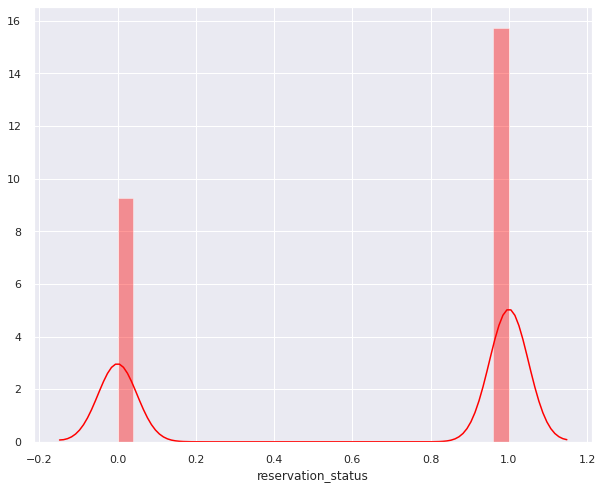

In [609]:
# plot the distribution for reservation_status rating of 0 lower and 1 as higher
plt.figure(figsize= (10,8))
sns.distplot(hotel_booked['reservation_status'], color='red');

### My target is a classification problem:
I have derived my target as a binary classification problem:to answer a binary questions whether the booking_status checked out:0 or canceled:1

### How many classes?

In [610]:
# I can assign my target to a variable is called my_target
my_target = hotel_booked['reservation_status'] 

In [611]:
# check for the first 10 reservation_status in my_target
my_target.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    0
9    0
Name: reservation_status, dtype: int64

In [612]:
# how many numbers of nunique values are in my target column?
my_target.nunique()

2

### There are two class, and they are binary classification problems

### Are the classes imbalanced?

In [613]:
# value counts for each class
my_target.value_counts(normalize=True)

1    0.629584
0    0.370416
Name: reservation_status, dtype: float64

In [614]:
# the max value counts
my_target.value_counts(normalize=True).max()

0.6295837172292487

### Sometimes, the majority class occurs with less than 50% frequency which can be a mis-leading. In this case, if it happens, accuracy is not good as an evaluation metrix.
For my target the majority class occurs with 62% frequency, so I gues this is not too imbalanced. I could just use accuracy score as my evaluation metric if I want to deep more there are other options like precision, recall, and roc-auc. Sometimes, the majority class occurs with less than 50% frequency which can be a mis-leading. In this case, if it happens, accuracy is not good.

### Choosing My Evaluation Metrixes
In addtion to Accuracy, I am going to use Precision and Recall, ROC_curve/AUC, Confusion-Metrix, and Classification Report.

### Begin With Cleaning Data and Exploratory Data Analysis

### Import Wrangle

In [615]:
# some information about the dataset
hotel_booked.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [616]:
# some some description about the dataset
hotel_booked.describe()

is_canceled  ...  reservation_status
count  119390.000000  ...       119390.000000
mean        0.370416  ...            0.629584
std         0.482918  ...            0.482918
min         0.000000  ...            0.000000
25%         0.000000  ...            0.000000
50%         0.000000  ...            1.000000
75%         1.000000  ...            1.000000
max         1.000000  ...            1.000000

[8 rows x 21 columns]

In [617]:
# checking for any missing values
hotel_booked.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### Exploratory And Data Analysis(EDA)

In [618]:
from pandas_profiling import ProfileReport
# pull the report profile for my dataset
profile = ProfileReport(hotel_booked, minimal=True).to_notebook_iframe()

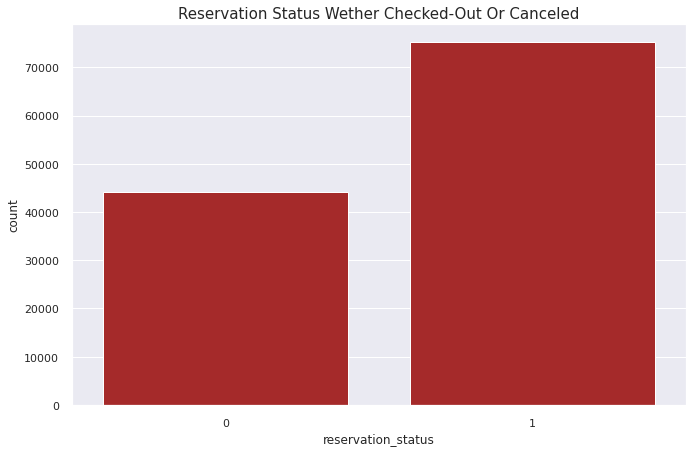

In [627]:
# use a seaborn countplot to plot reservation_status
plt.figure(figsize= (11,7))
ax = sns.countplot(x = "reservation_status", data = hotel_booked, color='brown', saturation=2, dodge=True);
sns.set(style = "darkgrid");
plt.title("Reservation Status Wether Checked-Out Or Canceled", fontdict = {'fontsize': 15});

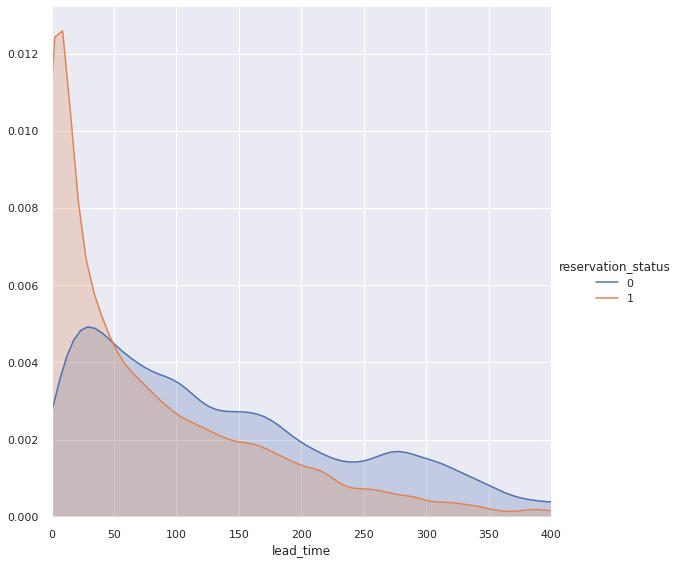

In [628]:
# make a density curve of lead time per booking_status
lead_booking = (sns.FacetGrid(hotel_booked, hue='reservation_status', height=8, xlim=(0,400), legend_out=True).map(sns.kdeplot, 'lead_time', shade=True).add_legend());

In [629]:
# it shows the difference of booking cancellations for th total amount of book canceled or not and the percentage(resort and city hotels)
resort_hotel = hotel_booked[hotel_booked["hotel"] == "Resort Hotel"]
city_hotel = hotel_booked[hotel_booked["hotel"] == "City Hotel"]

cancel_reso = pd.DataFrame(resort_hotel["is_canceled"].value_counts())
cancel_reso.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
cancel_reso["Status"] = cancel_reso.index

cancel_city = pd.DataFrame(city_hotel["is_canceled"].value_counts())
cancel_city.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
cancel_city["Status"] = cancel_city.index

# make a pie chart to show the differece book canceled for those hotels

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles = ["City Hotel", "Resort Hotel"])
fig.add_trace(go.Pie(values = cancel_city["booking_cancellations"], labels = cancel_city["Status"]),1,1)
fig.add_trace(go.Pie(values = cancel_reso["booking_cancellations"], labels = cancel_reso["Status"]),1,2)
fig.update_traces(textposition='inside', textinfo='value+percent+label')
fig.update_layout(title_text = "Type Of Booking Cancellations For City Hotel And Resort Hotel")
fig.show()

In [630]:
# scatter plot between reservation_status and lead_time
px.scatter(hotel_booked, x='reservation_status', y='lead_time', color='reservation_status', opacity=0.1)

(0.0, 170.0)

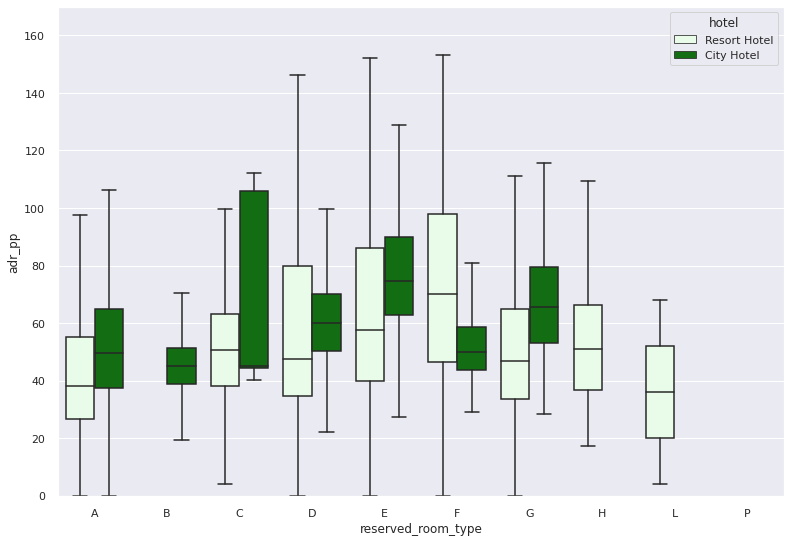

In [631]:
# add new feature engineering from existing adr column
# make a new column called total overnight cost in each hotel for guest
hotel_booked["adr_pp"] =hotel_booked["adr"] / (hotel_booked["adults"] + hotel_booked["children"])
room_guest = hotel_booked[hotel_booked["reservation_status"]== 0]
room_cost = room_guest[["hotel", "adr_pp", "reserved_room_type"]].sort_values("reserved_room_type")

plt.figure(figsize= (13,9))
sns.boxplot(x="reserved_room_type", y= "adr_pp", hue="hotel", data= room_cost, fliersize=0, color='green', saturation=0.70, width=0.8, dodge=True )
plt.ylim(0,170)

In [632]:
hotel_booked.head()

hotel  is_canceled  ...  reservation_status_date  adr_pp
0  Resort Hotel            0  ...               2015-07-01     0.0
1  Resort Hotel            0  ...               2015-07-01     0.0
2  Resort Hotel            0  ...               2015-07-02    75.0
3  Resort Hotel            0  ...               2015-07-02    75.0
4  Resort Hotel            0  ...               2015-07-03    49.0

[5 rows x 33 columns]

In [633]:
# countries that show the most total number of guests'homes for each hotel 
country_guest = pd.DataFrame(hotel_booked.loc[hotel_booked['is_repeated_guest'] == 0]["country"].value_counts())
country_guest.index.name = "country"
country_guest.rename(columns={"country": "Number of Guests"}, inplace=True)
total_num_guests = country_guest["Number of Guests"].sum()
country_guest["% Guests"] = round(country_guest["Number of Guests"] / total_num_guests * 100, 2)

In [634]:
# country per guest shows on the map
guest_per_country = px.choropleth(country_guest,
                    locations=country_guest.index,
                    color=country_guest["% Guests"], 
                    hover_name=country_guest.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="The Majority Countries That Guests Come From")
guest_per_country.show()

### My Wrangler Data Function
I have defined a function do all cleaning data and return my_wrangler_data

In [635]:
# define a wrangle function to deal with training, validation, and testing data
# Do some cleaning and making feature engineering
import numpy as np

def my_wrangler_data(X):
    
    # SettingWithCopyWarning
    X = X.copy()


    # replace those columns that have missing value and drop the subset of children
    null_values = {"country": "Unknown", "agent": 0, "company": 0}
    X = X.fillna(null_values)
    X.dropna(subset = ["children"], inplace = True)

    # droping all invalids entries for adults, children, babies, weekened-nights, week-night, and adr
    X.drop(X[(X["adults"] == 0) & (X["children"] == 0) & (X["babies"] == 0)].index, inplace = True)
    X.drop(X[(X["stays_in_weekend_nights"] == 0) & (X["stays_in_weekend_nights"] == 0) & (X["adr"] == 0)].index, inplace = True)
    

    # Ajdusting the some names of columns in the dataset
    X.rename(columns = {"is_canceled": "booking_cancellations","arrival_date_year":"year", "arrival_date_month":"month", "arrival_date_week_number": "week_number", "arrival_date_day_of_month":"day_of_month", "stays_in_weekend_nights":"weekend_nights", "stays_in_week_nights":"week_nights"}, inplace=True)
     

    # the different between booking cancellations in City Hotel and Resort Hotel
    resort_hotel = X[X["hotel"] == "Resort Hotel"]
    city_hotel =  X[X["hotel"] == "City Hotel"]

    cancel_reso = pd.DataFrame(resort_hotel["is_canceled"].value_counts())
    cancel_reso.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
    cancel_reso["Status"] = cancel_reso.index

    cancel_city = pd.DataFrame(city_hotel["is_canceled"].value_counts())
    cancel_city.rename(columns={"is_canceled": "booking_cancellations"}, index =({0: "No Canceled", 1:"Yes Canceled"}), inplace=True)
    cancel_city["Status"] = cancel_city.index


    # countries that show the most total number of guests for each hotel
    country_guest = pd.DataFrame(X.loc[X['is_repeated_guest'] == 0]["country"].value_counts())
    country_guest.index.name = "country"
    country_guest.rename(columns={"country": "Number of Guests"}, inplace=True)
    total_num_guests = country_guest["Number of Guests"].sum()
    country_guest["% Guests"] = round(country_guest["Number of Guests"] / total_num_guests * 100, 2)

    # add new feature engineering from existing adr column
    # make a new column called total overnight cost in each hotel for guest
    X["adr_pp"] = X["adr"] / (X["adults"] + X["children"])
    room_guest = X[X["reservation_status"]==0]
    room_cost = room_guest[["hotel", "adr_pp", "reserved_room_type"]].sort_values("reserved_room_type")

     
    # replace N-Show status canceled status
    X['reservation_status'] = X['reservation_status'].replace({'No-Show':'Canced'})
    
    # Add target feature
    if 'reservation_status' in X.columns:
      X['reservation_status'] = X['reservation_status'].apply(lambda x: 0 if x =='Canceled' else 1)
      

    # drop the reservation_status from the previous dataset
    X.drop('reservation_status', axis=1, inplace=True)


    # return my wrangler data function
    return X
  

    # Loading the dataset file and read it
    url_hotel = 'https://raw.githubusercontent.com/oyrx/PHBS_MLF_2019_Project/master/data/hotel_bookings.csv'

    hotel_booked = my_wrangler_data(pd.read_csv(url_hotel))


    # treat all my dataset at the same way for training, validation, and testing
    train = my_wrangler_data(train)
    val = my_wrangler_data(val)
    test = my_wrangler_data(test)

In [636]:
 hotel_booked['reservation_status']

0         1
1         1
2         1
3         1
4         1
         ..
119385    1
119386    1
119387    1
119388    1
119389    1
Name: reservation_status, Length: 119390, dtype: int64

### Choose which observations I will use to train, validate, and test my model

### Split Data

In [637]:
# Split my feature matrix and target vector
y = hotel_booked['reservation_status']
X = hotel_booked.drop(['reservation_status'], axis=1)

In [638]:
# train on reviews from 2015 & earlier. Validate on 2016. Test on 2017 & later
hotel_booked['reservation_status_date'] = pd.to_datetime(hotel_booked['reservation_status_date'])
train = hotel_booked[hotel_booked['reservation_status_date'].dt.year <= 2015]
val = hotel_booked[hotel_booked['reservation_status_date'].dt.year == 2016]
test =hotel_booked[hotel_booked['reservation_status_date'].dt.year >= 2017]

In [639]:
# prrint out all shapes for training data and validation data
print(train.shape)
print(train.shape)
print(val.shape)
print(val.shape)
print(test.shape)
print(test.shape)

(25110, 33)
(25110, 33)
(57797, 33)
(57797, 33)
(36483, 33)
(36483, 33)


### Begin to choose which features, if any, to exclude

In [640]:
# Selecting features
# The booking_status column is the my target
my_target = 'reservation_status'
 
# Get a dataframe with all train columns except the target and the high cardinalities
train_features = hotel_booked.columns.drop([my_target], 'reservation_status_date')

# Get a list of the numerical features and categorical_features
numerical_features = ['total_of_special_requests', 'lead_time', 'is_repeated_guest', 'previous_cancellations','previous_bookings_not_canceled',
                      'stays_in_week_nights', 'required_car_parking_spaces']
categorical_features = ['arrival_date_month', 'deposit_type', 'reserved_room_type','hotel', 'customer_type',
 'market_segment', 'meal']
 
# Combine all the lists 
my_features = numerical_features + categorical_features

In [641]:
# Arrange data into features matrix and target vector 
X_train = train[my_features]
y_train = train[my_target]
X_val = val[my_features]
y_val = val[my_target]
X_test = test[my_features]
y_test = test[my_target]

In [642]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(25110, 14)
(25110,)
(57797, 14)
(57797,)
(36483, 14)
(36483,)


In [643]:
# selecting some features to have in the future
my_features

['total_of_special_requests',
 'lead_time',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'stays_in_week_nights',
 'required_car_parking_spaces',
 'arrival_date_month',
 'deposit_type',
 'reserved_room_type',
 'hotel',
 'customer_type',
 'market_segment',
 'meal']

### BaseLine

In [644]:
# initial baseline traing, validation, and testing data that just to help me what I can predict for my building models
print('Baseline Training Accuracy:', y_train.value_counts(normalize=True).max())
print('Baseline Training Accuracy:', y_val.value_counts(normalize=True).max())
print('Baseline Training Accuracy:', y_test.value_counts(normalize=True).max())

Baseline Training Accuracy: 0.536121067303863
Baseline Training Accuracy: 0.6292541135353046
Baseline Training Accuracy: 0.6944330236000329


In [645]:
# appropriator importance estimators to setup python enironment
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics.scorer import check_scoring  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from eli5.permutation_importance import get_score_importances
from eli5.sklearn.utils import pandas_available

### On One Hot Encoder

In [646]:
# one hot encoder on all the non-numerical columns
encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
Logistic_model = LogisticRegression(max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_train_encoded.head()

total_of_special_requests  lead_time  ...  meal_SC  meal_Undefined
0                          0        342  ...        0               0
1                          0        737  ...        0               0
2                          0          7  ...        0               0
3                          0         13  ...        0               0
4                          1         14  ...        0               0

[5 rows x 49 columns]

### Building The Model With Decision Tree

In [647]:
tree_model = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       DecisionTreeClassifier(max_depth=6, random_state=42))

# Fitting the tree_model 
tree_model.fit(X_train, y_train);

# Check Evaluation Metrics for the tree_model
print('Traing Accuracy:', tree_model.score(X_train, y_train))
print('Validation Accuracy:', tree_model.score(X_val, y_val))

Traing Accuracy: 0.8927120669056153
Validation Accuracy: 0.552485423118847


### Would some features “leak” future information?

### So, in order to check for leakage. First I need to graph my model to see where is the leakage.

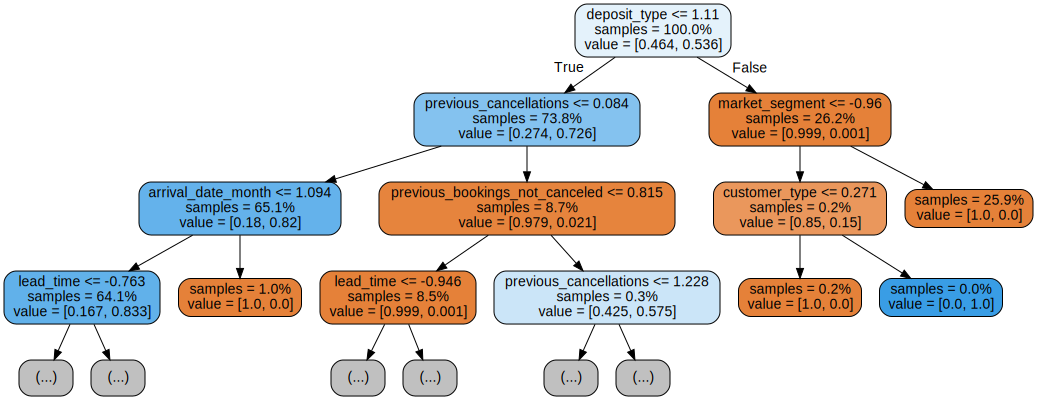

In [648]:
# Get the insight of the tree model
classifier = tree_model.named_steps['decisiontreeclassifier']
feature_names = tree_model.named_steps['ordinalencoder'].feature_names

# Making  a visualization for the tree
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(classifier, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=feature_names,
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

### No, all my training, validation, and testing data show less than a %100 accuracy, and that as a started point.
So, that mean some features “not very leak” future information. So, that was really good to check your accuracy. I can say If I got a %100 or close to it that means I was doing something wrong, and I shoud fix it first and move on the next step by droping that colum cause leakage. But in my case, there is no leakage.

### Building Model With Logistic

In [649]:
Logistic_model = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       LogisticRegression(max_iter=1000)
)

# Fitting the tree_model 
Logistic_model.fit(X_train, y_train);

# Check Evaluation Metrics for the logistic_model
print('Traing Accuracy:', Logistic_model.score(X_train, y_train))
print('Validation Accuracy:', Logistic_model.score(X_val, y_val))
print('Testing Accuracy:', Logistic_model.score(X_test, y_test))

Traing Accuracy: 0.882078853046595
Validation Accuracy: 0.72977836219873
Testing Accuracy: 0.7465120741167119


### Build The Model With RandomForest

In [652]:
# Make pipeline as a one package for all
Rand_forest = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
)

# Fitting the tree_model 
Rand_forest.fit(X_train, y_train);

# Check Evaluation Metrics for the Rand_forest
print('Traing Accuracy:', Rand_forest.score(X_train, y_train))
print('Validation Accuracy:', Rand_forest.score(X_val, y_val))

Traing Accuracy: 0.9740740740740741
Validation Accuracy: 0.558679516237867


### Importance Features

### With RandomForest Top 20 Importance Features

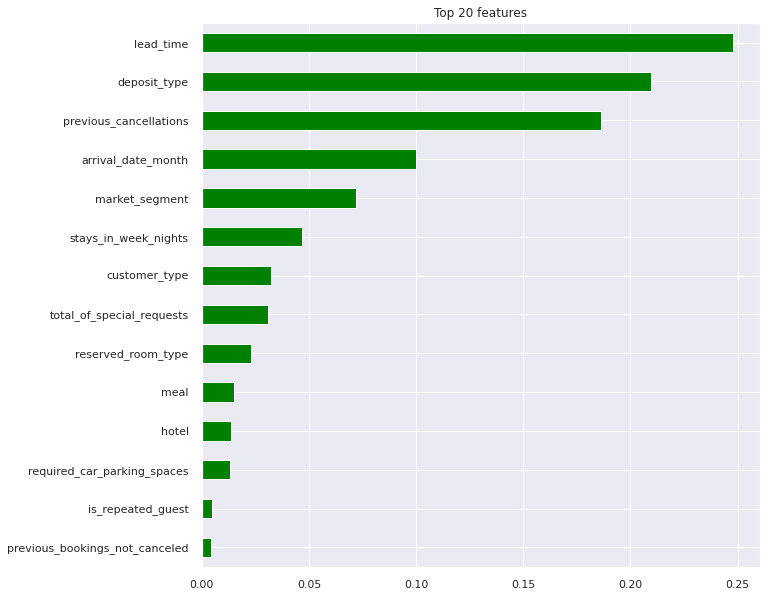

In [653]:
# make top 20 feature importances withe randomforst
classifier= Rand_forest.named_steps['randomforestclassifier']
f_importances = pd.Series(classifier.feature_importances_, X_train.columns)

# plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
f_importances.sort_values()[-n:].plot.barh(color='green');

### With Decision Tree Top 10 Importance Features

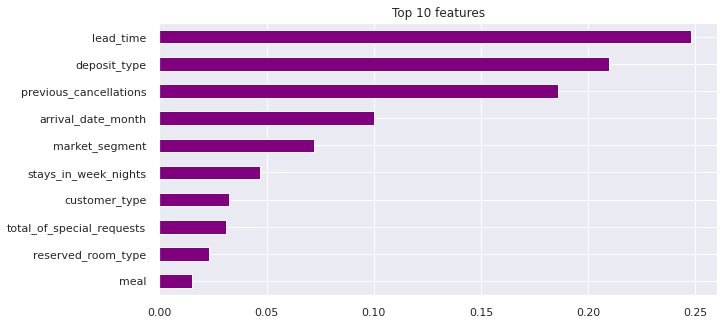

In [654]:
# Importance features of my tree to get the top 10 features
import matplotlib.pyplot as plt

# Get the insight of the tree model
classifier = tree_model.named_steps['decisiontreeclassifier']

feature_names = tree_model.named_steps['ordinalencoder'].feature_names

features_importances = classifier.feature_importances_
importances = pd.Series(features_importances, index=feature_names)

n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
f_importances.sort_values()[-n:].plot.barh(color='purple');

### Accuracy/Precision/ And Recall

In [655]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [656]:
# Predictor
y_pred = Logistic_model.predict(X_val)

# Accuracy
accuracy_score(y_val, y_pred)

0.72977836219873

In [657]:
# Precision
precision_score(y_val, y_pred, average='micro')

0.72977836219873

In [658]:
# Recall
recall_score(y_val, y_pred, pos_label=1, average='weighted' )

0.72977836219873

In [661]:
# predict a probability with roc_curve
y_predict_proba = Rand_forest.predict_proba(X_val)[:, -1]
fpr, tpr, thresholds = roc_curve(y_val, y_predict_proba)

In [662]:
# predict a probability of roc_curve table resualts
FP_TP_TR = pd.DataFrame({"False Positive Rate": fpr,
              "True Positive Rate": tpr,
              "Thresholds Rate": thresholds})
FP_TP_TR 

False Positive Rate  True Positive Rate  Thresholds Rate
0                0.000000            0.000000         2.000000
1                0.018434            0.081965         1.000000
2                0.018434            0.081993         0.999306
3                0.018434            0.082130         0.998936
4                0.018434            0.082185         0.997727
...                   ...                 ...              ...
1876             0.758680            0.974924         0.020833
1877             0.758680            0.974979         0.015000
1878             0.759240            0.974979         0.011842
1879             0.759334            0.974979         0.006250
1880             1.000000            1.000000         0.000000

[1881 rows x 3 columns]

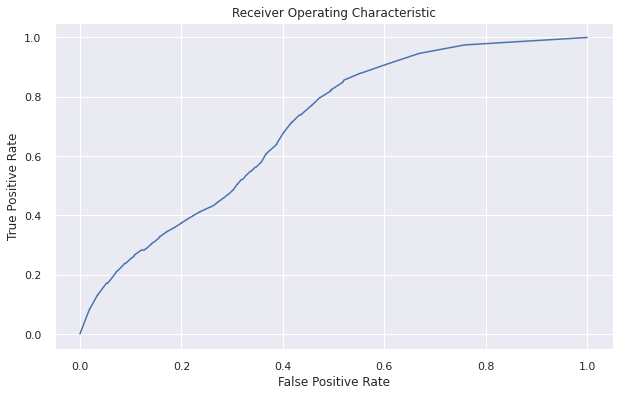

In [805]:
# plot the the roc_curve resualts
plt.figure(figsize=(10,6))
px.scatter(fpr, tpr);
plt.plot(fpr, tpr);
plt.title("Receiver Operating Characteristic")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.show()

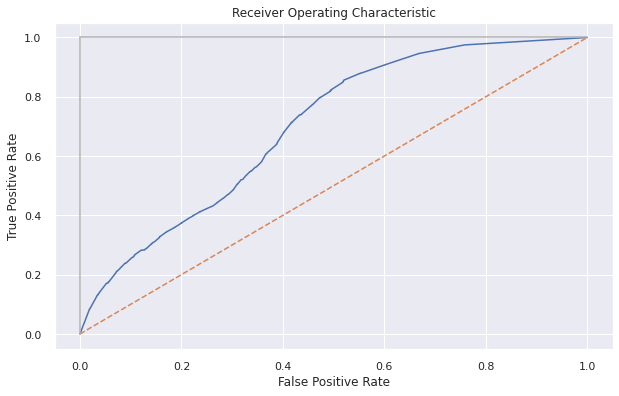

In [808]:
# predict a probability with roc_curve
y_predict_proba = Rand_forest.predict_proba(X_val)[:, -1]

# create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, y_predict_proba)

# Plot ROC curve
plt.figure(figsize=(10,6))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Tuning and Hyper Parametters

In [668]:
# Make pipeline as a one package for all
Rand_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
)

# using hyperparametter for RandomForest
paramtter = {'simpleimputer__strategy':['mean', 'most_frequent', 'median'],
             
             'randomforestclassifier__n_estimators': [5,10,20],
             'randomforestclassifier__criterion': ['gini','entropy'],  
             'randomforestclassifier__min_samples_split': [5,10,20],
             'randomforestclassifier__max_depth': [4,10,15], 
             'randomforestclassifier__min_samples_leaf': [5,10,20]}

In [669]:
research_r= RandomizedSearchCV(Rand_model,
                  param_distributions=paramtter,
                  n_iter=3,
                  n_jobs=-1,
                  return_train_score=True,
                  scoring='accuracy',
                  verbose=1,
                  cv=4)

In [670]:
# fitting the model
research_r.fit(X_train, y_train);

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.2s finished


In [671]:
best_rand_search = research_r.best_score_
best_estimator = research_r.best_params_
best_model_estimator = research_r.best_estimator_

In [672]:
print("Best Score:", research_r.best_score_ )
print("Best Rand Forest Score:",  research_r.best_score_)

Best Score: 0.8634892485869137
Best Rand Forest Score: 0.8634892485869137


In [673]:
print("Best Model:", research_r.best_estimator_)
print("Best Estimator:", research_r.best_params_)

Best Model: Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['arrival_date_month', 'deposit_type',
                                      'reserved_room_type', 'hotel',
                                      'customer_type', 'market_segment',
                                      'meal'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'arrival_date_month',
                                          'data_type': dtype('O'),
                                          'mapping': July          1
August        2
September     3
October       4
November      5
D...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=4, max_features='auto',
                                  

### Permutation & Boosting

### Xgboost For Gradient Boosting
It is with early stopping to prevent the overfitting and underfitting, and it is optimized hyperparametters with the best estimators. Also it helps to improve the model and select feature importances.

In [674]:
from xgboost import XGBClassifier

xgb_model = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    XGBClassifier(n_jobs=10, early_stopping_rounds=30)
)

# fit the model
xgb_model.fit(X_train, y_train);

In [675]:
print('Training Accuracy:', xgb_model.score(X_train, y_train))
print('Validation Accuracy:', xgb_model.score(X_val, y_val))

Training Accuracy: 0.894942254082039
Validation Accuracy: 0.5784037233766458


In [676]:
from xgboost.sklearn import XGBClassifier
from sklearn.inspection import permutation_importance

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [677]:
model_xgoost = XGBClassifier(n_estimators =20,
                             max_depth =5, 
                             learning_rate = .5,
                             n_jobs = -1)
evel_set = ((X_train_encoded, y_train),
(X_val_encoded, y_val)), (X_test_encoded, y_test)

model_xgoost.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [678]:
print('Training Accuracy:', model_xgoost.score(X_train_encoded, y_train))
print('Validation Accuracy:', model_xgoost.score(X_val_encoded, y_val))

Training Accuracy: 0.9081242532855436
Validation Accuracy: 0.5557381871031368


### Permutation Importance
Permutation Importance, I think it is very useful if we compromise between feature importance for reduction that it can be best or fastest.

In [679]:
#XGBoosting with hyperparametters

paramet = {
    'criterion': 'giny', 
    'learning_rate': 0.04, 
    'max_depth': 5,
    'n_estimators': 200, 
    'objective': 'binary:logistic', 
}

In [680]:
#XGB model
model_xgoost= XGBClassifier(parameters=paramet)

# fit the model
model_xgoost.fit(X_train_encoded, y_train)

# perform permutation importance
xgb_result = permutation_importance(model_xgoost, X_train_encoded, y_train, scoring='accuracy', n_repeats = 10, n_jobs=-1)
xgb_in = xgb_result.importances_mean.argsort()

In [681]:
# make table scores for features by using a for loop
for i,j in enumerate(xgb_in):
    print("Feature Scores: %0d, Score: %.5f " % (i,j))

Feature Scores: 0, Score: 5.00000 
Feature Scores: 1, Score: 13.00000 
Feature Scores: 2, Score: 2.00000 
Feature Scores: 3, Score: 9.00000 
Feature Scores: 4, Score: 10.00000 
Feature Scores: 5, Score: 0.00000 
Feature Scores: 6, Score: 6.00000 
Feature Scores: 7, Score: 11.00000 
Feature Scores: 8, Score: 4.00000 
Feature Scores: 9, Score: 12.00000 
Feature Scores: 10, Score: 1.00000 
Feature Scores: 11, Score: 7.00000 
Feature Scores: 12, Score: 3.00000 
Feature Scores: 13, Score: 8.00000 


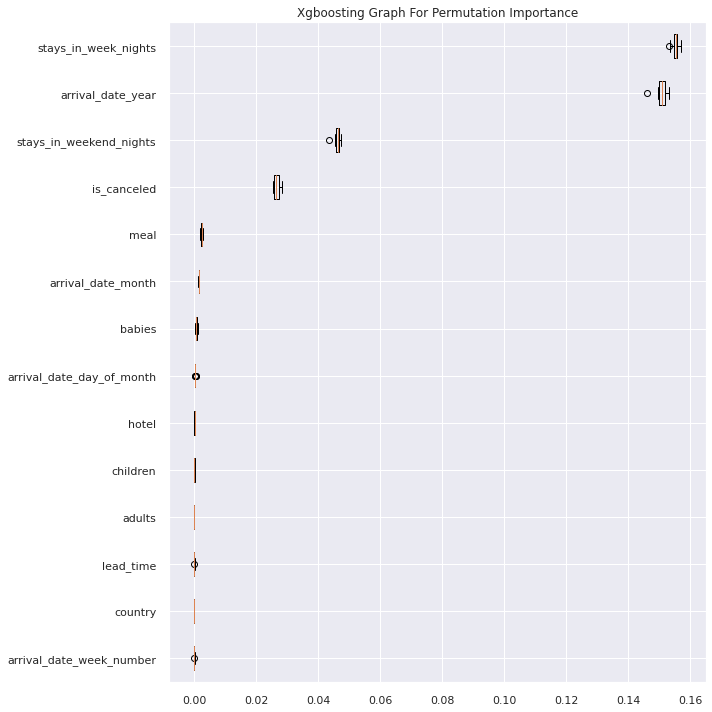

In [682]:
# Xgboosting graph for permutation importance

fig, ax = plt.subplots(figsize=(10,10))

ax.boxplot(xgb_result.importances[xgb_in].T,
           vert=False, labels=X.columns[xgb_in])
ax.set_title("Xgboosting Graph For Permutation Importance")
fig.tight_layout()
plt.show()

In [685]:
# tree decision model
tree_model1 = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       DecisionTreeClassifier(criterion= 'gini', min_samples_split=9,
                                  min_samples_leaf = 5, max_features = 'auto'))

# fit the model
tree_model1.fit(X_train_encoded, y_train);

#Predict Model
predict_tree = tree_model1.predict(X_test_encoded)

print("Testing Accuracy For Tree Model:", tree_model1.score(X_test_encoded, predict_randf))

Testing Accuracy For Tree Model: 0.879149192774717


In [686]:
# logistic model
Logistic_model1 = make_pipeline(ce.OrdinalEncoder(),
                       SimpleImputer(strategy='mean'), 
                       StandardScaler(),
                       LogisticRegression(max_iter=1000)
)

# fit the model
Logistic_model1.fit(X_train_encoded, y_train);

#Predict Model
predict_log = Logistic_model.predict(X_test_encoded)

print("Testing Accuracy For Logistic Model:", Logistic_model1.score(X_test_encoded, predict_log ))

Testing Accuracy For Logistic Model: 0.9395334813474769


In [687]:
# Randforest model
Rand_forest1 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1
                           , min_samples_leaf = 7, min_samples_split=8)
)

# fit the model
Rand_forest1.fit(X_train_encoded, y_train);

#Predict Model
predict_randf = Rand_forest1.predict(X_test_encoded)

print("Testing Accuracy For Random Forest:", Rand_forest1.score(X_test_encoded, predict_randf))

Testing Accuracy For Random Forest: 1.0


In [688]:
# extreme gradient boosting to predict the model 
model_xgoost = XGBClassifier(criterion = 'giny', learning_rate = 0.02, max_depth = 6, n_estimators = 200,
                          objective ='binary:logistic', subsample = 1.0)
# fit the model
model_xgoost.fit(X_train_encoded, y_train);

#Predict Model
predict_xgb  = model_xgoost.predict(X_test_encoded)


print("Testing Accuracy For XGBoosting Model:", model_xgoost.score(X_test_encoded, predict_xgb))

Testing Accuracy For XGBoosting Model: 1.0


### Classification Reports For Models

In [695]:
# Classification Reports for all models
print("Decision Tree Model", classification_report(y_test, predict_tree))
print("Logistic Model",classification_report(y_test, predict_log))
print("Random Forest Model", classification_report(y_test, predict_randf))
print("XGBoosting", classification_report(y_test, predict_xgb))

Decision Tree Model               precision    recall  f1-score   support

           0       0.33      0.76      0.46     11148
           1       0.76      0.33      0.46     25335

    accuracy                           0.46     36483
   macro avg       0.54      0.54      0.46     36483
weighted avg       0.63      0.46      0.46     36483

Logistic Model               precision    recall  f1-score   support

           0       0.62      0.00      0.00     11148
           1       0.69      1.00      0.82     25335

    accuracy                           0.69     36483
   macro avg       0.66      0.50      0.41     36483
weighted avg       0.67      0.69      0.57     36483

Random Forest Model               precision    recall  f1-score   support

           0       0.31      0.74      0.44     11148
           1       0.71      0.28      0.40     25335

    accuracy                           0.42     36483
   macro avg       0.51      0.51      0.42     36483
weighted avg       

### Confusion Matrix For Models

In [696]:
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix

# Confusion Matrix 
tree_matrix = confusion_matrix(y_test, predict_tree)
log_matrix = confusion_matrix(y_test, predict_log)
randf_matrix = confusion_matrix(y_test, predict_randf)
xgb_matrix = confusion_matrix(y_test, predict_xgb)

### Plot All The Confusion Matrixes

Text(564.5454545454544, 0.5, 'Actual Labels')

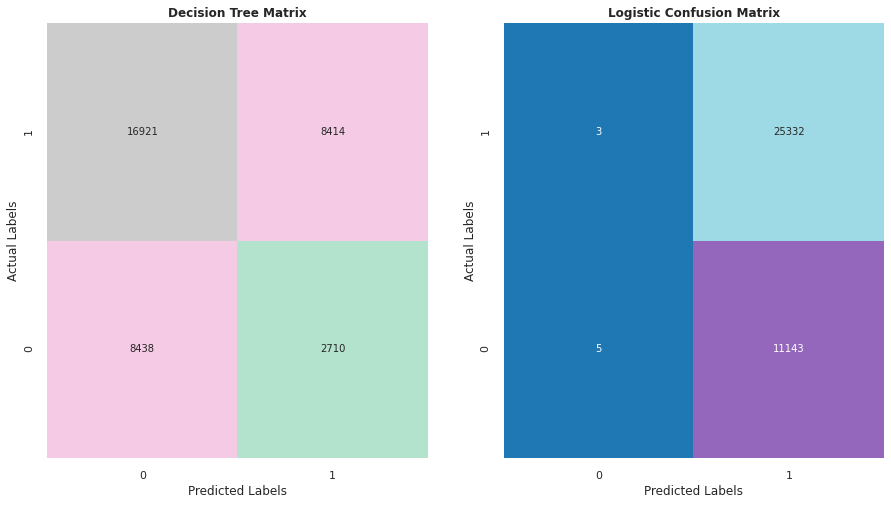

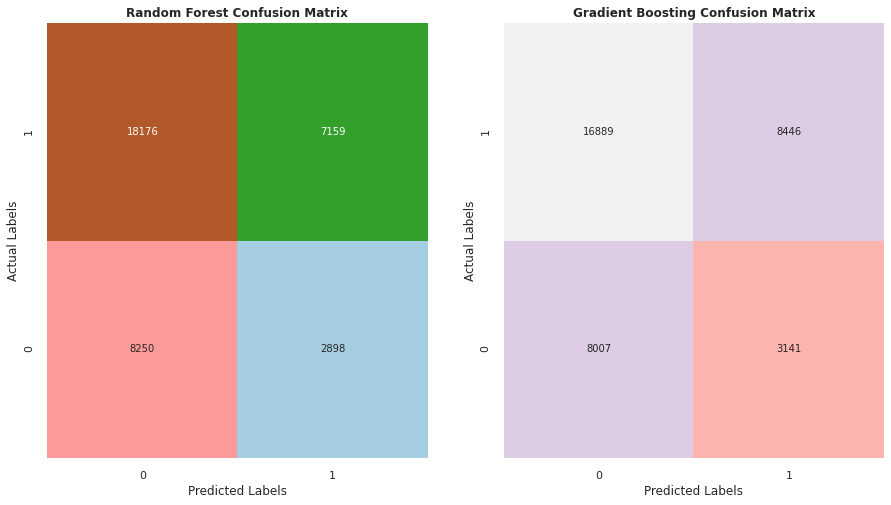

In [697]:
# plot all the confusion matrixes for models
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(tree_matrix,annot=True, fmt="d", cbar=False, cmap="Pastel2",  ax = ax[0]).set_ylim([0,2])
ax[0].set_title("Decision Tree Matrix", weight='bold')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('Actual Labels')

sns.heatmap(log_matrix ,annot=True, fmt="d" ,cbar=False, cmap="tab20", ax = ax[1]).set_ylim([0,2])
ax[1].set_title("Logistic Confusion Matrix", weight='bold')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('Actual Labels')

fig, axe = plt.subplots(1, 2, figsize=(15, 8))

sns.heatmap(randf_matrix,annot=True, fmt="d", cbar=False, cmap="Paired", ax = axe[0]).set_ylim([0,2])
axe[0].set_title("Random Forest Confusion Matrix", weight='bold')
axe[0].set_xlabel('Predicted Labels')
axe[0].set_ylabel('Actual Labels')

sns.heatmap(xgb_matrix ,annot=True, fmt="d", cbar=False, cmap="Pastel1", ax = axe[1]).set_ylim([0,2])
axe[1].set_title("Gradient Boosting Confusion Matrix", weight='bold')
axe[1].set_xlabel('Predicted Labels')
axe[1].set_ylabel('Actual Labels')

### PermutationImportance With Eli5

In [698]:
import eli5
from eli5.sklearn import PermutationImportance

In [699]:
model_predictor = Rand_forest.named_steps['randomforestclassifier']

Rand_pipeline = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'))

# fit the model
Rand_pipeline.fit(X_train, y_train)

# transform the model
TT_val = Rand_pipeline.transform(X_val)

model_permuter = PermutationImportance(
    model_predictor,
    scoring='accuracy',
    n_iter=7,
    random_state=42
)

model_permuter.fit(TT_val, y_val);

In [700]:
# eli5 graph with weight and feature with my 14 selecting features
eli5.show_weights(
    model_permuter,
    top=None,
    feature_names=X_val.columns.tolist()
)

### Model Interpretation

### Partial Dependence Plots with 2 features

In [701]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [708]:
plt.rcParams['figure.dpi']=72
pdf_feature = ['previous_bookings_not_canceled', 'previous_cancellations']

isolated_features = pdp_isolate(
    model=Rand_forest, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=pdf_feature
)

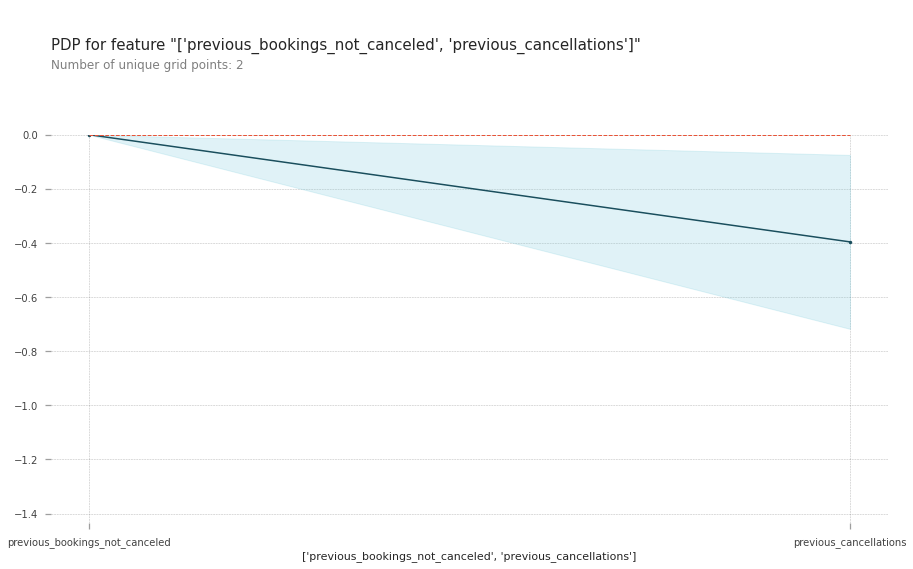

In [709]:
pdp_plot(isolated_features, feature_name=feature);

In [714]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

# PDF between total of special request and previous cancellations 
# it shows that the numbers of how many unique grid points for each 
# total of special requestis 4 and previous cancellation is 2
pdf_features = ['total_of_special_requests', 'previous_cancellations']

booking_interaction = pdp_interact(
    model=Rand_forest, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=pdf_features
)

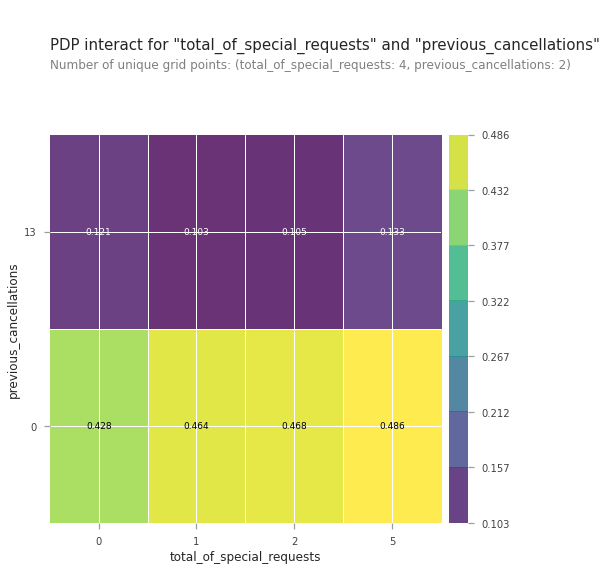

In [718]:
# this  multiple classes which is total of special request and previous cancellations
# with numbers of grid points that 4:2
pdp_interact_plot(booking_interaction, plot_type='grid', 
                  feature_names=pdf_features);

### Shapley Values
It is a good technique to show the insight of the model predictor and break down each model individually.

In [781]:
# explain the individual observation
# if I want to look for the second row from X_test
# turn it into a datafrme
second_row=X_test_encoded.iloc[[0]]
second_row

total_of_special_requests  lead_time  ...  market_segment  meal
9788                          1         89  ...             3.0     1

[1 rows x 14 columns]

In [774]:
# what is the actual reservation status for the hotel booking
# by the y_test for the second row which is canceled
y_test.iloc[[1]]

9805    0
Name: reservation_status, dtype: int64

In [782]:
# what is the model prediction for the hotel booking
research_r.predict(second_row)

array([1])

In [783]:
# explain why the model predict checkout by using shapley values force plot
import shap

model_explain = shap.TreeExplainer(model_xgoost)
shap_values = model_explain.shap_values(X_test_encoded.iloc[1])

In [784]:
# make a shapely plot
shap.initjs()
shap.force_plot(
    base_value=model_explain.expected_value, shap_values=shap_values, features=second_row
    )

In [785]:
# fit the encoder
X_test_encoded=encoder.fit_transform(X_test, y_train)

In [789]:
# get an individual row  for explaination
row=X_test_encoded.iloc[[2]]
row.columns

Index(['total_of_special_requests', 'lead_time', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'stays_in_week_nights', 'required_car_parking_spaces',
       'arrival_date_month', 'deposit_type', 'reserved_room_type', 'hotel',
       'customer_type', 'market_segment', 'meal'],
      dtype='object')

In [790]:
# what is the reservation status for these features
y_test.iloc[[2]]

9809    0
Name: reservation_status, dtype: int64

In [791]:
# model prediction for second row

model_xgoost.predict(row)

array([0])

In [792]:
#using Shapley Force Plot to explain the prediction

import shap

explainer= shap.TreeExplainer(model_xgoost)
shap_values= explainer.shap_values(row)


shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row)

In [793]:
#base value 
#baseline mean
explainer.expected_value, y_train.mean()

(0.19247139, 0.536121067303863)

In [794]:
feature_names= row.columns
feature_values=row.values[0]
shaps= pd.Series(shap_values[0], zip( feature_names, feature_values))
shaps

(total_of_special_requests, 2.0)         0.022751
(lead_time, 112.0)                      -0.315682
(is_repeated_guest, 0.0)                 0.002519
(previous_cancellations, 0.0)            0.207157
(previous_bookings_not_canceled, 0.0)   -0.009009
(stays_in_week_nights, 4.0)             -0.006755
(required_car_parking_spaces, 0.0)      -0.108622
(arrival_date_month, 7.0)               -3.394818
(deposit_type, 1.0)                      0.547842
(reserved_room_type, 3.0)                0.000371
(hotel, 1.0)                            -0.065370
(customer_type, 1.0)                     0.003679
(market_segment, 3.0)                   -0.244924
(meal, 1.0)                              0.000497
dtype: float32

In [795]:
# calculate predicted value manually
explainer.expected_value +shaps.sum()

-3.167892

In [797]:
# make a prediction function
def predict(total_of_special_requests, lead_time, is_repeated_guest,
       previous_cancellations, previous_bookings_not_canceled,
       stays_in_week_nights, required_car_parking_spaces,
       arrival_date_month, deposit_type, reserved_room_type, hotel,
       customer_type, market_segment, meal):

  #Make dataframe from inputs
  df_book = pd.DataFrame(
      data = [[total_of_special_requests, lead_time, is_repeated_guest,
       previous_cancellations, previous_bookings_not_canceled,
       stays_in_week_nights, required_car_parking_spaces,
       arrival_date_month, deposit_type, reserved_room_type, hotel,
       customer_type, market_segment, meal]],
      columns = ['total_of_special_requests', 'lead_time', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'stays_in_week_nights', 'required_car_parking_spaces',
       'arrival_date_month', 'deposit_type', 'reserved_room_type', 'hotel',
       'customer_type', 'market_segment', 'meal']
      )
  
  print(df_book)
  #Get model's prediction
  pred=model_xgoost.predict(df_book)[0]

  #Calculate the shap values
  model_explainer=shap.TreeExplainer(model_xgoost)
  shap_values=model_explainer.shap_values(df_book)

  #Get series with shap values, feature names & feature values
  feature_names=df_book.columns
  feature_values=df_book.values[0]
  shaps=pd.Series(shap_values[0], zip(feature_names, feature_values))

  res = f'${pred:,.02f}'
  res +=shaps.to_string()
  print(model_explainer.expected_value)
  print(res)

  # show shapley values force plot
  shap.initjs()
  return shap.force_plot(
      base_value=model_explainer.expected_value,
      shap_values=shap_values,
      features=df_book
  )

predict(30,20,10,5, 1, 2, 3,4,5,6,7,8,9,10)

   total_of_special_requests  lead_time  ...  market_segment  meal
0                         30         20  ...               9    10

[1 rows x 14 columns]
0.19247139
$0.00(total_of_special_requests, 30)        0.006569
(lead_time, 20)                        0.069342
(is_repeated_guest, 10)               -0.009942
(previous_cancellations, 5)           -2.323099
(previous_bookings_not_canceled, 1)    0.417136
(stays_in_week_nights, 2)             -0.003845
(required_car_parking_spaces, 3)       0.708283
(arrival_date_month, 4)                0.080510
(deposit_type, 5)                     -3.807252
(reserved_room_type, 6)                0.000254
(hotel, 7)                             0.008997
(customer_type, 8)                     0.010956
(market_segment, 9)                   -0.033234
(meal, 10)                             0.009288
